<a href="https://colab.research.google.com/github/Joshua-Pow/pokescanner/blob/main/PokeScanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Importing libraries / Data Loading and Splitting



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from os import rename, listdir, path
import math
import shutil

torch.manual_seed(1) # set the random seed

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #Must have folder inside drive called PokeScanner

trainingTransform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

data_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

Mounted at /content/gdrive


In [2]:
use_cuda = True
# filePath = '/content/gdrive/MyDrive/PokeScanner' #Everyone has had this folder shared with them, Right click the folder and click "Add shortcut to Drive"

# i = 0
# j = 0
# items = listdir("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned")
# print(items)
# for i in range (0, len(items)):
#   if (os.path.isdir("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/"+ items[i])):
#     dirItems = listdir("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/"+ items[i])
#     trainingNumber = math.floor(len(dirItems) * 0.80) 
#     validationNumber = math.floor(len(dirItems) * 0.10)
#     for j in range (0, len(dirItems)):
#      if (os.path.isfile("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/" + items[i] + "/" + dirItems[j])):
#        if (j <= trainingNumber):
#         shutil.copyfile("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/" + items[i] + "/" + dirItems[j], "/content/gdrive/MyDrive/PokeScanner/Training/" + items[i] + "/" + dirItems[j])
#        elif (j <= trainingNumber + validationNumber):
#         shutil.copyfile("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/" + items[i] + "/" + dirItems[j], "/content/gdrive/MyDrive/PokeScanner/Validation/" + items[i] + "/" + dirItems[j])
#        else:
#         shutil.copyfile("/content/gdrive/MyDrive/PokeScanner/PokemonDataCleaned/" + items[i] + "/" + dirItems[j], "/content/gdrive/MyDrive/PokeScanner/Testing/" + items[i] + "/" + dirItems[j])

# train_set = datasets.ImageFolder("/content/gdrive/MyDrive/PokeScanner/Training")
# validation_set = datasets.ImageFolder("/content/gdrive/MyDrive/PokeScanner/Validation")
# testing_set = datasets.ImageFolder("/content/gdrive/MyDrive/PokeScanner/Testing")

# print('Number of Training Images:', len(train_set))
# print('Number of Validation Images:', len(validation_set))
# print('Number of Testing Images:', len(testing_set))

In [3]:
filePath = '/content/gdrive/MyDrive/PokeScanner' #Everyone has had this folder shared with them, Right click the folder and click "Add shortcut to Drive"
training_set = []
training_set.append(datasets.ImageFolder(filePath+'/Training', transform=trainingTransform))
training_set.append(datasets.ImageFolder(filePath+'/NewTraining', transform=trainingTransform))
train_set = torch.utils.data.ConcatDataset(training_set) #Combine rotated data and regular data
validation_set = datasets.ImageFolder(filePath+'/Validation', transform=data_transform)
testing_set = datasets.ImageFolder(filePath+'/Testing', transform=data_transform)

###2. Generating More Data

In [4]:
# filePath = '/content/gdrive/MyDrive/PokeScanner/Training/'
# items = listdir(filePath)

# for i in range (0, len(items)):
#   pokemonPath = filePath + items[i]
#   pokeImages = listdir(pokemonPath)
  
#   for j in range (0, len(pokeImages)):
#     image1 = Image.open(pokemonPath + "/" + pokeImages[j])
#     image2 = image1.copy()
#     image2 = image2.transpose(PIL.Image.FLIP_LEFT_RIGHT)

#     fileName = pokeImages[j]
#     pokemonName = fileName.split('.')
#     image2.save(pokemonPath + "/" + pokemonName[0] + "FH.jpg")

### 3. Model Building and Sanity Checking

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the pokemon

In [5]:
import torchvision.models as models
efficientnet_b0 = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [6]:
batch_size  = 1
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [7]:
# #This saves all the computed features at the file paths for training, testing and validation
# pokemonTracker = [None] * 150
# for itr in range(len(pokemonTracker)):
#   pokemonTracker[itr] = 0

# items = listdir("/content/gdrive/MyDrive/PokeScanner/Training/")
# sortedItems = sorted(items)

# for img, label in iter(train_loader):
#   features = efficientnet_b0.features(img)
#   torch.save(features.squeeze(0), '/content/gdrive/MyDrive/PokeScanner/TrainingFeatures/' + sortedItems[label[0].item()] + '/' + sortedItems[label[0].item()] + str(pokemonTracker[label[0].item()]) + '.tensor')
#   pokemonTracker[label[0].item()] += 1

# for img, label in iter(validation_loader):
#   features = efficientnet_b0.features(img)
#   torch.save(features.squeeze(0), '/content/gdrive/MyDrive/PokeScanner/ValidationFeatures/' + sortedItems[label[0].item()] + '/' + sortedItems[label[0].item()] + str(pokemonTracker[label[0].item()]) + '.tensor')
#   pokemonTracker[label[0].item()] += 1

# for img, label in iter(test_loader):
#   features = efficientnet_b0.features(img)
#   torch.save(features.squeeze(0), '/content/gdrive/MyDrive/PokeScanner/TestingFeatures/' + sortedItems[label[0].item()] + '/' + sortedItems[label[0].item()] + str(pokemonTracker[label[0].item()]) + '.tensor')
#   pokemonTracker[label[0].item()] += 1

In [8]:
class PokemonClassifier(nn.Module):
    def __init__(self):
        super(PokemonClassifier, self).__init__()
        self.fc1 = nn.Linear(62720, 900)
        self.fc2 = nn.Linear(900, 150)

    def forward(self, x):
        x = x.view(-1, 62720) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
transferNetTrain = datasets.DatasetFolder('/content/gdrive/MyDrive/PokeScanner/TrainingFeatures', loader=torch.load, extensions=('.tensor'))
transferNetValid = datasets.DatasetFolder('/content/gdrive/MyDrive/PokeScanner/ValidationFeatures', loader=torch.load, extensions=('.tensor'))
transferNetTest = datasets.DatasetFolder('/content/gdrive/MyDrive/PokeScanner/TestingFeatures', loader=torch.load, extensions=('.tensor'))

In [10]:
#From tut3a
def get_accuracy(model, accuracy_data, batch_size):
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(accuracy_data, batch_size=batch_size):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        else:
          print("get_accuracy: no cuda")
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [11]:
#From tut3a
def train(model, data, size, num_epochs, learning_rate):
    train_loader = torch.utils.data.DataLoader(data, batch_size=size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc, epochList = [], [], [], [], []
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            else:
              print("Train: no cuda")
            #############################################
            # print("img: ", imgs.shape)
            # print("label: ", labels)
            out = model(imgs)             # forward pass
            
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/size)             # compute *average* loss
            n += 1
        train_acc.append(get_accuracy(model, accuracy_data=data, batch_size=size)) # compute training accuracy 
        val_acc.append(get_accuracy(model, accuracy_data=transferNetValid, batch_size=size))  # compute validation accuracy
        epochList.append(epoch)
        print("Epoch {}: Training Accuracy: {} Validation Accuracy: {}".format(epoch, train_acc[epoch], val_acc[epoch]))
    
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochList, train_acc, label="Train")
    plt.plot(epochList, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
  


In [12]:
model = PokemonClassifier()

#proper model
#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Cuda!")
#############################################

#Basic first attempt at training
#train(model, transferNetTrain, size=64, num_epochs=10, learning_rate=0.001)

Cuda!


In [13]:
PATH = "/content/gdrive/MyDrive/PokeScanner/FinalModel1.pt"
#torch.save(model, PATH)

In [ ]:
model.eval()
get_accuracy(model, transferNetTest, 64)

In [15]:
model = torch.load(PATH)

Most probable:  Wartortle
Second most probable:  Machop
Third most probable:  Cubone


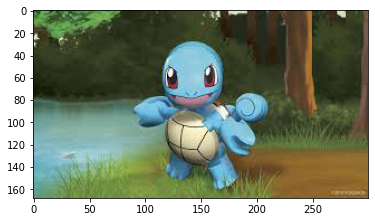

In [248]:
from PIL import Image
model.cuda()
model.eval()
# Read a PIL image
imgs = []
# imgs.append(Image.open('/content/gdrive/MyDrive/PokeScanner/char1.jpg'))
# imgs.append(Image.open('/content/gdrive/MyDrive/PokeScanner/char2.jpg'))
# imgs.append(Image.open('/content/gdrive/MyDrive/PokeScanner/char3.jpg'))
# imgs.append(Image.open('/content/gdrive/MyDrive/PokeScanner/squirtle.jpg'))
# imgs.append(Image.open('/content/gdrive/MyDrive/PokeScanner/wartortle.jpg'))
# imgs.append(Image.open('/content/gdrive/MyDrive/PokeScanner/blastoise.jpeg'))
imgs.append(Image.open('/content/gdrive/MyDrive/PokeScanner/squirtle.jpg'))
  
# Define a transform to convert PIL 
# image to a Torch tensor
transform = transforms.Compose([
  transforms.Resize(256),                 
  transforms.CenterCrop(224),        
  transforms.ToTensor(),        
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for image in imgs:
  # transform = transforms.PILToTensor()
  # Convert the PIL image to Torch tensor
  img_tensor = transform(image)
    
  # print the converted Torch tensor
  img_tensor.cuda()
  batch_t = torch.unsqueeze(img_tensor, 0)
  features = efficientnet_b0.features(batch_t)
  out = model(features.cuda().squeeze(0))
  temp = torch.sigmoid(out)
  temp = nn.Softmax(dim=1)(temp)
  pred = temp.max(1, keepdim=True)[1]

  items = listdir("/content/gdrive/MyDrive/PokeScanner/Training/")
  sortedItems = sorted(items)
  res, ind = torch.topk(temp, 3)
  print("Most probable: ", sortedItems[ind[0][0]])
  print("Second most probable: ",sortedItems[ind[0][1]])
  print("Third most probable: ",sortedItems[ind[0][2]])
  imag = image.rotate(0)
  plt.imshow(imag)
  

In [175]:
model = torch.load(PATH)

model.eval()
get_accuracy(model, transferNetTest, 64)

0.702865761689291